In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Load data

In [3]:
trace2 = np.genfromtxt('trace2.txt')
len2 = trace2.shape[0]
t = np.arange(0,60,1/20000)

In [4]:
# plt.figure(figsize = (20,4))
# plt.plot(t, trace2)
# plt.title('Trace2')
# plt.ylabel('Voltage, microV')
# plt.xlabel('Time, s')

Text(0.5, 0, 'Time, s')

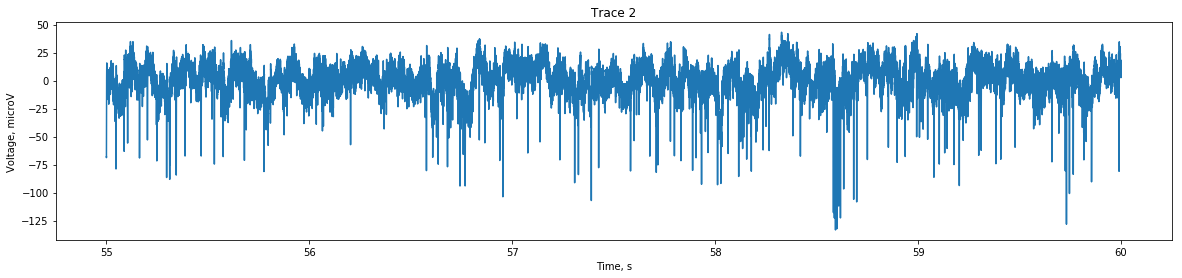

In [5]:
thr1 = len2 - 100000
thr2 = len2
plt.figure(figsize = (20,4))
plt.plot(t[thr1:thr2], trace2[thr1:thr2])
plt.title('Trace 2')
plt.ylabel('Voltage, microV')
plt.xlabel('Time, s')

### Transform the trace

In [6]:
T = 100
smooth_spike = np.empty(len2 - T)
for time in range(len2-T):
    smooth_spike[time] = sum(trace2[time:time+T])/T
smooth_t = t[int(T/2):-int(T/2)]
new_trace2 = trace2[int(T/2):-int(T/2)] - smooth_spike

Text(0.5, 0, 'Time, s')

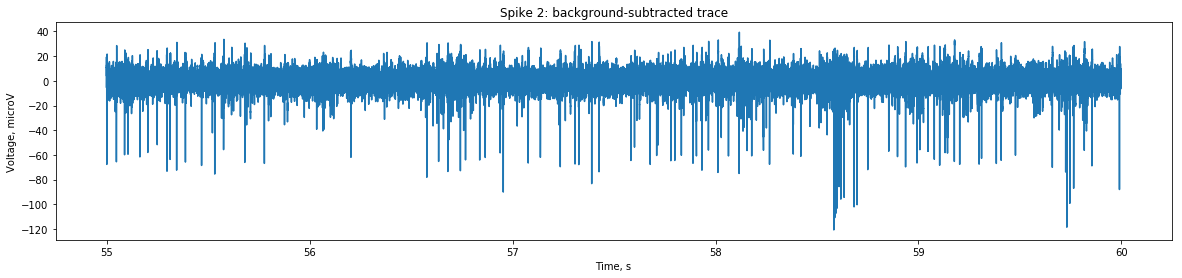

In [7]:
thr1 = len(smooth_t)-100000
thr2 = len(smooth_t)
plt.figure(figsize = (20,4))
plt.plot(smooth_t[thr1:thr2], new_trace2[thr1:thr2])
plt.title('Spike 2: background-subtracted trace')
plt.ylabel('Voltage, microV')
plt.xlabel('Time, s')

### Select threshold and spikes

In [8]:
spike_thr = np.arange(-30, -75,-5)

n_smooth_spikes = []
for thr in spike_thr:
    down_spikes = []
    for i, V in enumerate(new_trace2):
        if (V < thr) & (new_trace2[i-1] > thr):
            down_spikes.append((i, V))
    n_smooth_spikes.append(len(down_spikes))

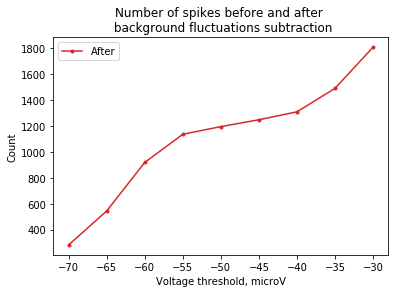

In [9]:
plt.figure(figsize = (6,4))
plt.plot(spike_thr, n_smooth_spikes, '.-',color = 'C3', label = 'After')
plt.title('Number of spikes before and after \n background fluctuations subtraction')
plt.ylabel('Count')
plt.xlabel('Voltage threshold, microV')
plt.legend()

In [10]:
thr = -50
spikes = []
for i in range(len(new_trace2)):
    if (new_trace2[i] < thr) & (new_trace2[i-1] > thr):
        spikes.append(new_trace2[i-30:i+30])
spikes = np.array(spikes)

In [175]:
spikes.shape

(1194, 60)

Text(0, 0.5, 'Voltage, uV')

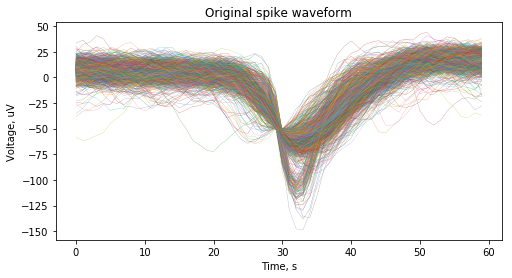

In [36]:
plt.figure(figsize = (8,4))
for i in range(len(spikes)):
    plt.plot(np.arange(60), spikes[i], linewidth = 0.2)
plt.title('Original spike waveform')
plt.xlabel('Time, s')
plt.ylabel('Voltage, uV')

In [13]:
spikes.shape

(1194, 60)

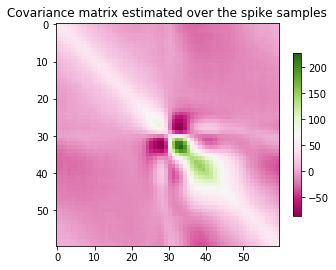

In [26]:
plt.figure(figsize = (5,5))
plt.title("Covariance matrix estimated over the spike samples")
plt.imshow(np.cov(spikes.T), cmap = 'PiYG')
plt.colorbar(shrink = 0.6)

### Run PCA

In [41]:
pca = PCA(n_components=2, copy = True, random_state = 45)
spikes_2PC = pca.fit_transform(spikes)

Text(0, 0.5, 'PC2')

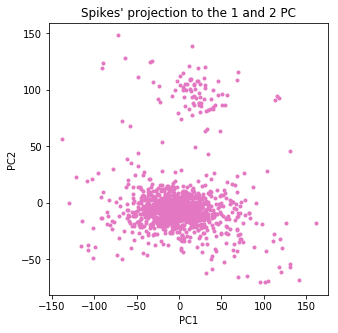

In [42]:
plt.figure(figsize = (5,5))
plt.title("Spikes' projection to the 1 and 2 PC")
spikes_firstPC = list(zip(*spikes_2PC))[0]
spikes_secPC = list(zip(*spikes_2PC))[1]
plt.scatter(spikes_firstPC, spikes_secPC, marker = '.', color = 'C6')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [40]:
# pca.explained_variance_ratio_
# pca.singular_values_
# pca.components_

In [44]:
# plt.figure(figsize = (8,4))
# # plt.plot(np.arange(60), np.mean(spikes, axis = 0), label = 'Spike mean')
# plt.plot(range(60),pca.components_[0], label = 'PC1')
# plt.plot(range(60),pca.components_[1], label = 'PC2')
# plt.title('Mean spike waveform and 2 PC')
# plt.xlabel('Time, s')
# plt.ylabel('Voltage, uV')
# plt.legend()

### Clustering...

In [137]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', copy_x = True, random_state = 45)
labels_2PC = kmeans.fit_predict(spikes_2PC)
transf_spikes_2PC = kmeans.fit_transform(spikes_2PC)
centers = kmeans.cluster_centers_
sep_point = (centers[1]+centers[0])/2

In [186]:
sum(labels_2PC)

90

In [164]:
a_ort = -((centers[1]-centers[0])[0])/((centers[1]-centers[0])[1])
b_ort = sep_point[1] - a_ort * sep_point[0]

Text(0, 0.5, 'PC2')

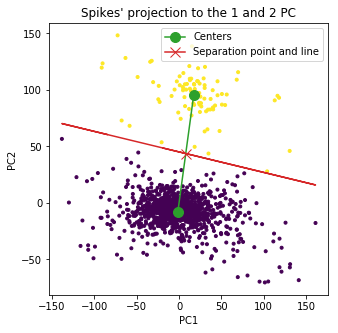

In [181]:
plt.figure(figsize = (5,5))
plt.title("Spikes' projection to the 1 and 2 PC")
spikes_firstPC = np.array(list(zip(*spikes_2PC))[0])
spikes_secPC = np.array(list(zip(*spikes_2PC))[1])
plt.scatter(spikes_firstPC, spikes_secPC, marker = '.', c = labels_2PC)
plt.plot(centers[:,0], centers[:,1], marker = 'o', label = 'Centers', ms = 10, color = 'C2')
plt.plot(sep_point[0], separation_point[1], marker = 'x', ms = 10, color = 'C3', label = 'Separation point and line')
plt.plot(spikes_firstPC, a_ort*spikes_firstPC+b_ort, color = 'C3')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

In [168]:
separation = pca.inverse_transform(sep_point)

Text(0, 0.5, 'Voltage, uV')

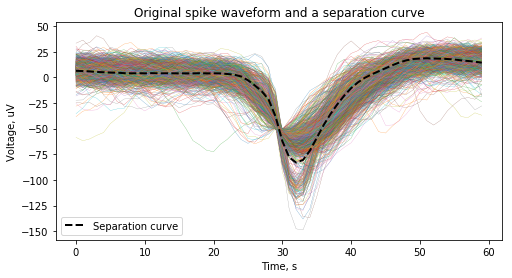

In [174]:
plt.figure(figsize = (8,4))
for i in range(len(spikes)):
    plt.plot(np.arange(60), spikes[i], linewidth = 0.2)
plt.plot(np.arange(60), separation, linewidth = 2, color = 'black', ls = '--', label = 'Separation curve')
plt.legend()
plt.title('Original spike waveform and a separation curve')
plt.xlabel('Time, s')
plt.ylabel('Voltage, uV')

In [191]:
spikes[np.where(labels_2PC)[0]].shape

(90, 60)

Text(0, 0.5, 'Voltage, uV')

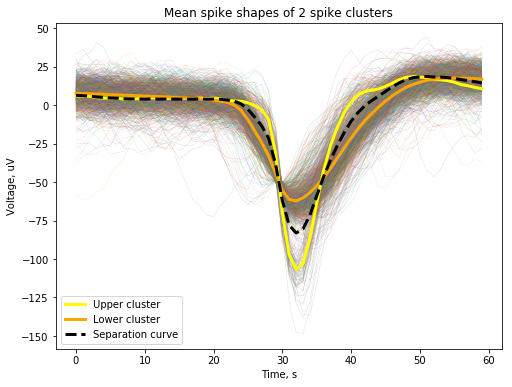

In [213]:
plt.figure(figsize = (8,6))
for i in range(len(spikes)):
    plt.plot(np.arange(60), spikes[i], linewidth = 0.2, alpha = 0.5)
plt.plot(np.arange(60), np.mean(spikes[np.where(labels_2PC)[0]], axis = 0),linewidth= 3,
         color = 'yellow', label = 'Upper cluster')
plt.plot(np.arange(60), np.mean(spikes[np.where(labels_2PC == 0)[0]], axis = 0), linewidth= 3, 
         color = 'orange', label = 'Lower cluster')
plt.plot(np.arange(60), separation, linewidth = 3, color = 'black', 
         ls = '--', label = 'Separation curve')
plt.legend()
plt.title('Mean spike shapes of 2 spike clusters')
plt.xlabel('Time, s')
plt.ylabel('Voltage, uV')